In [1]:
%cd ../../

/notebooks/mt-tabnet-xgboost-model-comparison


In [38]:
import pickle
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt

# Tabnet

In [3]:
def load_metrics(model,size,eval_no):
    with open(f'results/{model}/{size}/{eval_no}/metrics.p','rb') as f:
        metrics = pickle.load(f)
    return metrics

def load_res_pickle(model,size,eval_no,file):
    with open(f'results/{model}/{size}/{eval_no}/{file}','rb') as f:
        metrics = pickle.load(f)
    return metrics  


def load_metric_arr(model,size,eval_start=0,eval_end=30):
    metrics = []
    for i in range(eval_start,eval_end):
        metrics.append(load_metrics(model,size,i))
    return metrics

In [8]:
metrics_arr = load_metric_arr("tabnet","small")

In [9]:
metrics_arr[0]

{'mcc': 0.2813191833523201,
 'f1': 0.8037090405675167,
 'confusion_m': array([[  326,   128,    52,    15],
        [ 2108, 40637,  5289,  2626],
        [  131,  1039,  1570,   362],
        [   59,  1115,   570,   880]]),
 'acc': 0.7628762718119037}

In [10]:
def get_conf_interval(losses):
    mean  =np.mean(losses)
    interval = st.t.interval(0.95, len(losses)-1, loc=np.mean(losses), scale=st.sem(losses))
    return (mean,mean-interval[0])

In [11]:
for metric in ["mcc","f1","acc"]:
    print(f"#####{metric}#######")
    for size in ["large","medium","small"]:
        metrics_arr = load_metric_arr("tabnet", size,eval_end=30)
        metrics = [metrics[metric] for metrics in metrics_arr]
        print(size+":")
        print(f"min: {min(metrics)} max:{max(metrics)}")
        print(get_conf_interval(metrics))

#####mcc#######
large:
min: 0.22851711540266997 max:0.36737000578754
(0.3073024877873339, 0.013690697735832591)
medium:
min: -0.013248061053001813 max:0.300269115632304
(0.17938894189764484, 0.03485662163345565)
small:
min: 0.27053769322978416 max:0.3351429914808357
(0.3005359355563642, 0.006460937148877632)
#####f1#######
large:
min: 0.7518720772700136 max:0.8248549693067916
(0.7953567568258754, 0.006263114348526999)
medium:
min: 0.29231957286203714 max:0.8153554259327167
(0.739795631811027, 0.039504157216049496)
small:
min: 0.7760339810734198 max:0.8367204493273049
(0.8112887300593931, 0.00540430963563332)
#####acc#######
large:
min: 0.68583071648605 max:0.7926016001574502
(0.7479405836550576, 0.009490512062853451)
medium:
min: 0.2003268490695345 max:0.8016588468905407
(0.6820736757633801, 0.046845244861993596)
small:
min: 0.7180838912611806 max:0.8170875287750189
(0.7743669495844097, 0.008925124749807334)


In [54]:
conf_dict_tabnet = dict()
for size in ["large","medium","small"]:
    enumerated = list(enumerate(load_metric_arr("tabnet", size,eval_end=30)))
    enumerated.sort(key=lambda x: x[1]['mcc'])
    print(f"Best {size} eval: {enumerated[1][0]}")
    print(enumerated[0][1]['confusion_m'])
    conf_dict_tabnet[size]=enumerated[1][1]['confusion_m']

Best large eval: 3
[[  1320   3246    145    499]
 [ 19685 397223  50137  39554]
 [  2404  10420  13465   4732]
 [  1035   9944   7875   7385]]
Best medium eval: 17
[[  114   132    96   179]
 [10453  9876 14345 15986]
 [  978   547  1023   554]
 [  697   560   980   387]]
Best small eval: 12
[[   21   449    16    35]
 [  948 42618  3901  3193]
 [   24  1237  1298   543]
 [   34  1068   448  1074]]


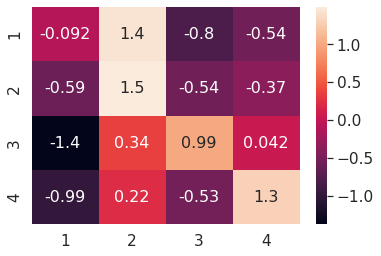

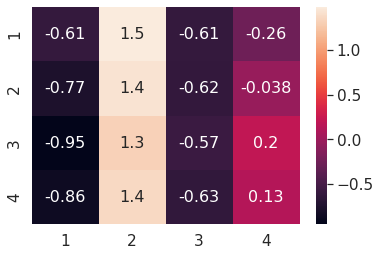

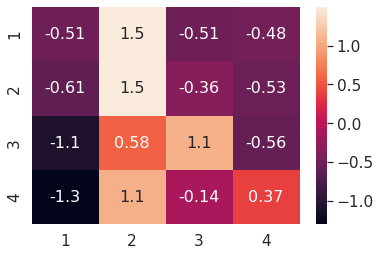

In [55]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

for size in ["large","medium","small"]:

    array = conf_dict_tabnet[size]

    df = pd.DataFrame(array, range(1,5), range(1,5))
    df_norm_col=(df-df.mean())/df.std()
    df_norm_row = df.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_norm_row, annot=True, annot_kws={"size": 16}) # font size
    #plt.show()
    plt.savefig(f'../../figs/tabnet/{size}/conf_mat.png')
    plt.show()

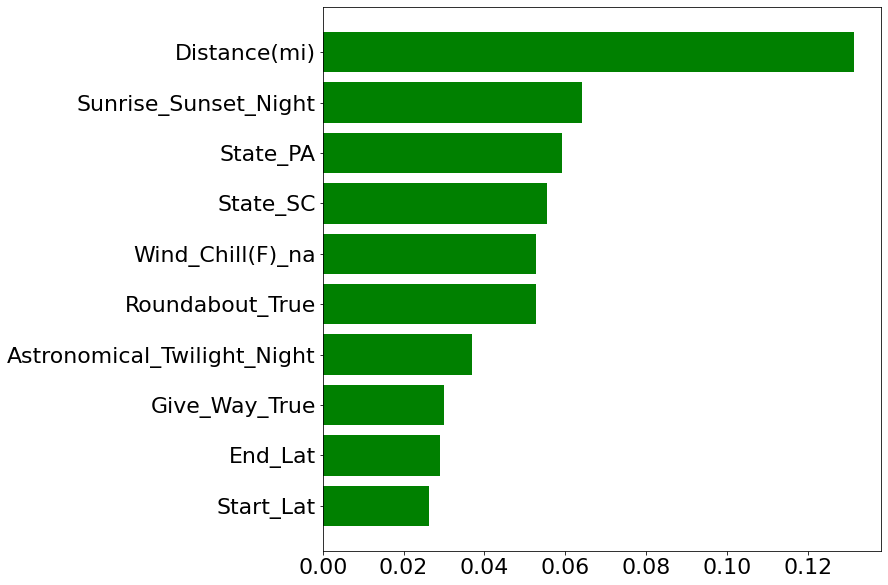

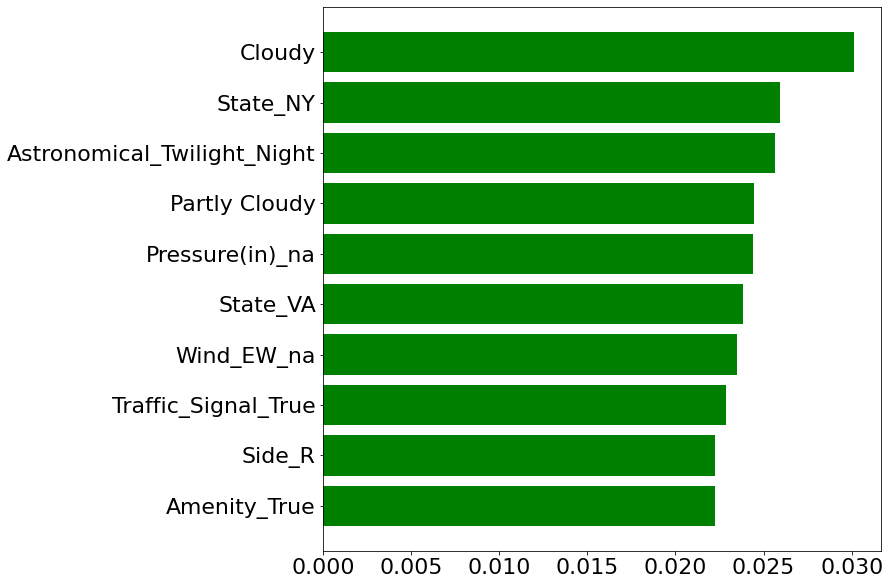

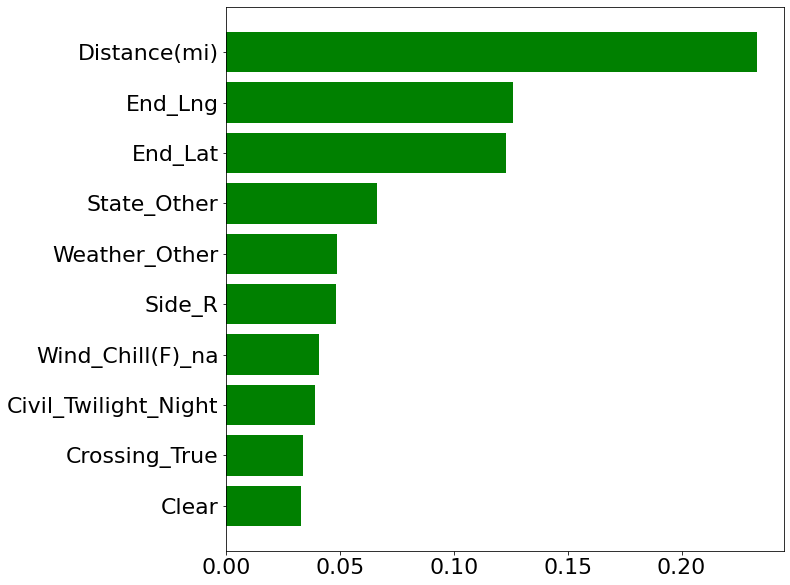

In [51]:
from model_trainer.tabnet import utils
for size,eval_no in zip(["large","medium","small"],[18,13,18]):
    feature_and_res = load_res_pickle("tabnet",size,eval_no,"feature_and_res.p")
    names = feature_and_res['x_names']
    importances = feature_and_res['feature_importances']
    sortedarr  = list(zip(names,importances))
    sortedarr.sort(key=lambda x: x[1])
    sortedarr = sortedarr[-10:]
    names_sorted = [item[0] for item in sortedarr]
    importances = [item[1] for item in sortedarr]
    plot_feature_importances(importances,names_sorted,show=False)
    plt.savefig(f'figs/tabnet/{size}/features.png',bbox_inches='tight')
    plt.show(),

# XGBoost

In [77]:
for metric in ["mcc","f1","acc"]:
    print(f"#####{metric}#######")
    for size in ["large","medium","small"]:
        metrics_arr = load_metric_arr("xgboost", size,eval_end=10)
        print(size+":")
        print(get_conf_interval([metrics[metric] for metrics in metrics_arr]))

#####mcc#######
large:
(0.4549338505329864, 1.1102230246251565e-16)
medium:
(0.4081669166241505, 5.551115123125783e-17)
small:
(0.3893962585493149, nan)
#####f1#######
large:
(0.8481695607587628, nan)
medium:
(0.8458788410962619, nan)
small:
(0.8265425238112984, 1.1102230246251565e-16)
#####acc#######
large:
(0.8184262365372212, 1.1102230246251565e-16)
medium:
(0.8188096367757922, 1.1102230246251565e-16)
small:
(0.7899555414975311, nan)


In [75]:
metrics_arr = load_metric_arr("tabnet", "medium")
mccs=[metrics['mcc'] for metrics in metrics_arr]
mccs

[0.23060239400590687,
 0.251439712465042,
 0.10128243937788876,
 0.2593089766086897,
 0.07184896724936418,
 0.1166340216998051,
 0.2617267922599594,
 0.09098748857407395,
 0.2499231751515342,
 0.2646579916121721,
 0.2841377858480764,
 0.2449000510980161,
 0.25781408342502704,
 -0.013248061053001813,
 0.23035490480561338,
 0.20687236587022514,
 0.2546643883622662,
 0.02536801282610338,
 0.08897410727259734,
 0.27766565132258325,
 0.23782917835637926,
 0.07683526409444501,
 0.2268263522965376,
 0.0758923238142683,
 0.038710845754042475,
 0.14122980103816843,
 0.300269115632304,
 0.23205092653782705,
 0.06599723619818672,
 0.23011196442524473]

In [22]:
conf_dict_xgboost= dict()
for size in ["large","medium","small"]:
    enumerated = list(enumerate(load_metric_arr("xgboost", size,eval_end=1)))
    enumerated.sort(key=lambda x: x[1]['mcc'])
    print(f"Best {size} eval: {enumerated[0][0]}")
    print(enumerated[0][1]['confusion_m'])
    conf_dict_xgboost[size]=enumerated[0][1]['confusion_m']

Best large eval: 0
[[  4640    295    234     41]
 [ 10869 422824  44401  28505]
 [   888   5221  21573   3339]
 [   267   5633   3635  16704]]
Best medium eval: 0
[[  419    64    30     8]
 [ 1113 42958  4168  2421]
 [   84   736  1913   369]
 [   27   851   440  1306]]
Best small eval: 0
[[  449    39    25     8]
 [ 1544 41137  4869  3110]
 [  114   620  1986   382]
 [   36   762   444  1382]]


In [23]:
conf_dict_xgboost

{'large': array([[  4640,    295,    234,     41],
        [ 10869, 422824,  44401,  28505],
        [   888,   5221,  21573,   3339],
        [   267,   5633,   3635,  16704]]),
 'medium': array([[  419,    64,    30,     8],
        [ 1113, 42958,  4168,  2421],
        [   84,   736,  1913,   369],
        [   27,   851,   440,  1306]]),
 'small': array([[  449,    39,    25,     8],
        [ 1544, 41137,  4869,  3110],
        [  114,   620,  1986,   382],
        [   36,   762,   444,  1382]])}

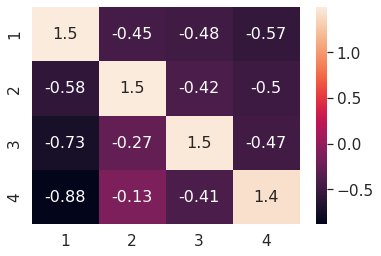

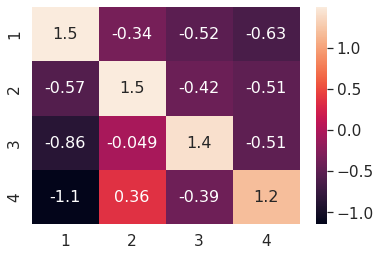

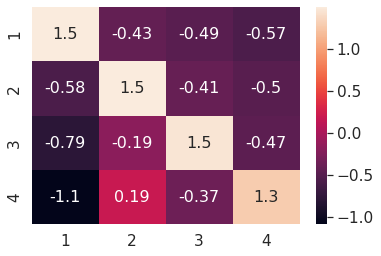

In [52]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

for size in ["large","medium","small"]:

    array = conf_dict_xgboost[size]

    df = pd.DataFrame(array, range(1,5), range(1,5))
    df_norm_col=(df-df.mean())/df.std()
    df_norm_row = df.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_norm_row, annot=True, annot_kws={"size": 16}) # font size
    #plt.show()
    plt.savefig(f'../../figs/xgboost/{size}/conf_mat.png')
    plt.show()


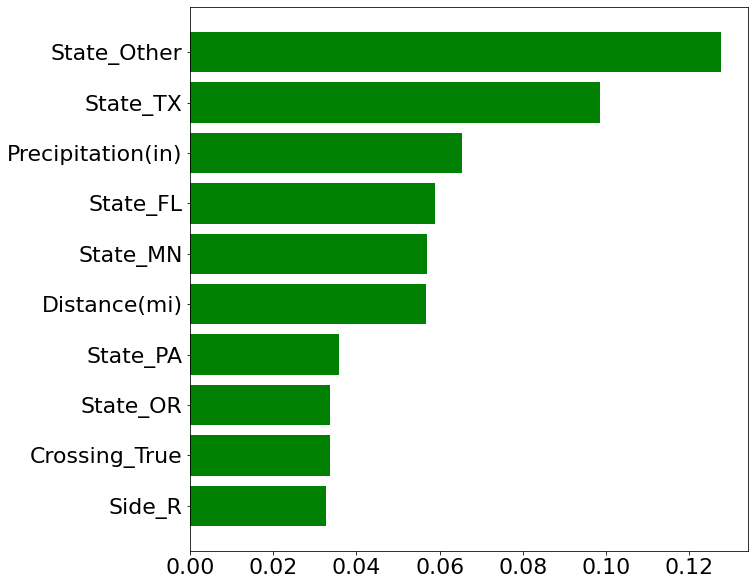

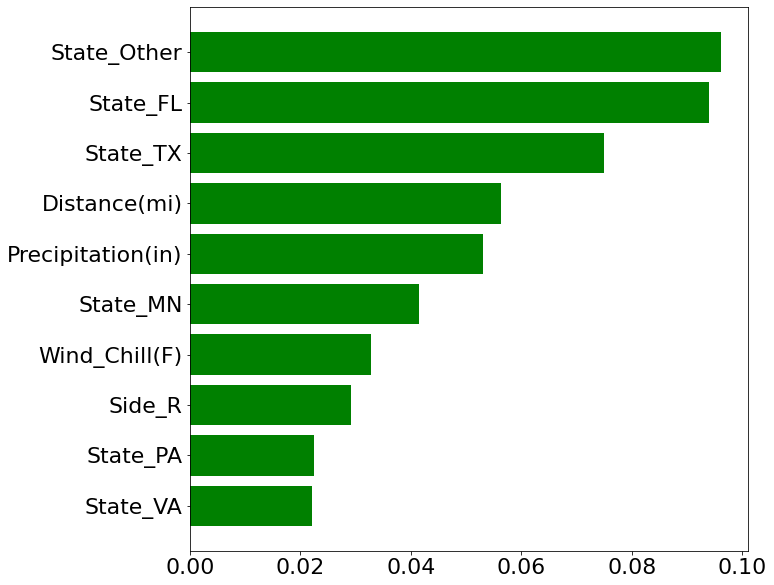

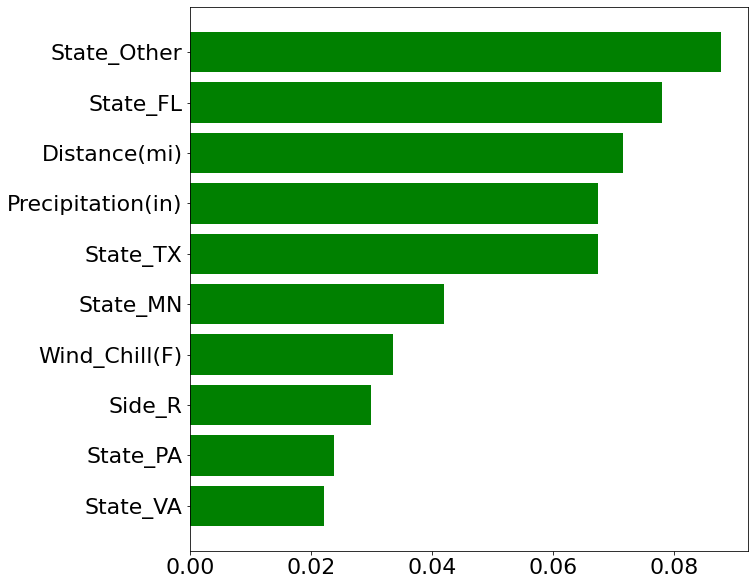

In [50]:
from model_trainer.tabnet import utils
for size,eval_no in zip(["large","medium","small"],[30,30,30]):
    feature_and_res = load_res_pickle("xgboost",size,eval_no,"features.p")
    names = feature_and_res['names']
    importances = feature_and_res['importances']
    sortedarr  = list(zip(names,importances))
    sortedarr.sort(key=lambda x: x[1])
    sortedarr = sortedarr[-10:]
    names_sorted = [item[0] for item in sortedarr]
    importances = [item[1] for item in sortedarr]
    plot_feature_importances(importances,names_sorted,show=False)
    plt.savefig(f'figs/xgboost/{size}/features.png',bbox_inches='tight')
    plt.show()

In [46]:
def plot_feature_importances(feature_importances, lbls, figsize=(10, 10),show=True):
    plt.figure(figsize=figsize)
    plt.xticks(rotation='horizontal')
    plt.barh(lbls, feature_importances, color='g')
    if(show):
        plt.show()